<a href="https://colab.research.google.com/github/harvard-visionlab/psy1406/blob/main/2022/psy1406_project01_facenet_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psy1406 - Project01 - FaceNet Notebook

# Goals
This notebook will allow you to probe the representations of a deep, convolutional neural network trained to represent faces (FaceNet). Specifically, you can upload images, pass them through the FaceNet deep neural network, and then evaluate how similar the images are in the low-dimensional "embedding space" of the network.

What images? That depends on your question. The primary goal is to probe whether FaceNet shows human-like face processing, or whether it's judgments of face similarity line up with your own (using your self as proxy for "what humans see").

You can try anything here:
- Do I look more like my mother or father?
- Which Celebrity to I look most similar to?
- Does FaceNet show wholistic face processing?
- Does FaceNet show the thatcher illusion?
- Does FaceNet show a composite face effect?
- Does FaceNet see similarity across age (google images "age progression")?
- Does facenet's embedding have separate dimensions for features of faces, like a unit that responds to "age", one that responds to "hair color", one that responds to "eye-color" or "skin tone", etc.?
- Does facenet have any biases, e.g., relying on skin color when judgming similarity?

# Instructions
* The cells of this notebook are intended to be run in order. To run a cell, place the cursor in the cell and hit "Shift + Enter".
* You can also run entire sections by collapsing the section (arrows on the left of header cells), and click the "play button" to run all the cells in that section.
* You'll be turning in a copy of this notebook and some powerpoint slides (see Step 9 below). Your powerpoint presentation can literally be just two slides, a screenshot of the images you use, and screenshot of the results. No text needed, because in class we'll just put up your slides and you'll talk about what images you presented, why you presented them (what question you were trying to answer), and then show us the results and what you think it means. You might need two slides for each variation you test (e.g., if you tested a hypothesis with a new image set, take a snapshot of the images and results.

# Step 0 - General Setup

Running this section will download some demo images and install some code needed to run the following setps. You should only need to run this step once at the start of a session. However, sometimes Google restarts your environment (e.g., if you are idle for a while, they shut down your session), so you might have to re-run this step if that happens.

In [ ]:
# INSTALL FACENET 
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
# DOWNLOAD EXAMPLE IMAGES
!mkdir -p images
!wget -c https://www.dropbox.com/s/7tqlvb69lvx570h/BaldBear.jpg -q --show-progress -O /content/images/BaldBear.jpg
!wget -c https://www.dropbox.com/s/nbct96tf4oqnr2q/BrownBear2.jpg -q --show-progress -O /content/images/BrownBear.jpg
!wget -c https://www.dropbox.com/s/65p68g331kby809/Gorilla.jpg -q --show-progress -O /content/images/Gorilla.jpg
!wget -c https://www.dropbox.com/s/be1hkifaz8u04y9/DiCaprio_Anchor.jpg -q --show-progress -O /content/images/DiCaprio_Anchor.jpg
!wget -c https://www.dropbox.com/s/xn3y46bpccopdl7/DiCaprio_HardNegative.jpg -q --show-progress -O /content/images/DiCaprio_HardNegative.jpg
!wget -c https://www.dropbox.com/s/8londclzzyj3oji/DiCaprio_NegativeClooney.jpg -q --show-progress -O /content/images/DiCaprio_NegativeClooney.jpg
!wget -c https://www.dropbox.com/s/ddlfya3368jdhci/DiCaprio_Positive.jpg -q --show-progress -O /content/images/DiCaprio_Positive.jpg

/content/images/Bal 100%[===================>]  96.21K  --.-KB/s    in 0.03s   
/content/images/Bro 100%[===================>] 221.81K  --.-KB/s    in 0.03s   
/content/images/Gor 100%[===================>] 145.40K  --.-KB/s    in 0.03s   
/content/images/DiC 100%[===================>]  62.19K  --.-KB/s    in 0.02s   
/content/images/DiC 100%[===================>]  51.92K  --.-KB/s    in 0.02s   
/content/images/DiC 100%[===================>]   3.50M  --.-KB/s    in 0.09s   
/content/images/DiC 100%[===================>]  60.30K  --.-KB/s    in 0.02s   


In [ ]:
import os
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%config InlineBackend.figure_format='retina'
# %matplotlib notebook
%matplotlib inline
sns.set(rc={'figure.figsize':(15.7,8.27)})
np.set_printoptions(suppress=True)

class ImageListDataset(Dataset):
    """"""

    def __init__(self, imgs, transform=None):
        self.root_dir = None
        self.files = imgs
        self.transform = transform

    def __getitem__(self, index):
        im = Image.open(self.files[index])
        if self.transform:
            im = self.transform(im)

        return im, 0, index

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        _repr_indent = 4
        head = "Dataset " + self.__class__.__name__
        body = ["Number of Images: {}".format(self.__len__())]
        if self.root_dir is not None:
            body.append("Root location: {}".format(self.root_dir))
        if hasattr(self, "transform") and self.transform is not None:
            body += [repr(self.transform)]
        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)


def get_dataset(image_pairs, root_dir=Path('images')):
    root_dir = Path(root_dir)
    transform = transforms.Compose([
        lambda x: x.convert('RGB'),
        transforms.Resize((224, 224)),
    ])
    imgs = [root_dir/img for imgs in image_pairs for img in imgs]
    dataset = ImageListDataset(imgs=imgs, transform=transform)

    return dataset


def show_grid(dataset):
    imgs = []
    for image_num in range(0, len(dataset), 2):
        imgs.append(np.hstack(
            [np.array(dataset[image_num][0]), np.array(dataset[image_num+1][0])]))
    imgs = np.vstack(imgs)

    return Image.fromarray(imgs)

'''
Utilities for instrumenting a torch model.
InstrumentedModel will wrap a pytorch model and allow hooking
arbitrary layers to monitor or modify their output directly.
'''

import torch
import numpy
import types
import copy
from collections import OrderedDict, defaultdict


class InstrumentedModel(torch.nn.Module):
    '''
    A wrapper for hooking, probing and intervening in pytorch Modules.
    Example usage:
    ```
    model = load_my_model()
    with inst as InstrumentedModel(model):
        inst.retain_layer(layername)
        inst.edit_layer(layername, ablation=0.5, replacement=target_features)
        inst(inputs)
        original_features = inst.retained_layer(layername)
    ```
    '''

    def __init__(self, model):
        super().__init__()
        self.model = model
        self._retained = OrderedDict()
        self._detach_retained = {}
        self._editargs = defaultdict(dict)
        self._editrule = {}
        self._hooked_layer = {}
        self._old_forward = {}
        if isinstance(model, torch.nn.Sequential):
            self._hook_sequential()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

    def retain_layer(self, layername, detach=True):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and retain its output each time the model is run.
        A pair (layername, aka) can be provided, and the aka will be used
        as the key for the retained value instead of the layername.
        '''
        self.retain_layers([layername], detach=detach)

    def retain_layers(self, layernames, detach=True):
        '''
        Retains a list of a layers at once.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka not in self._retained:
                self._retained[aka] = None
                self._detach_retained[aka] = detach

    def stop_retaining_layers(self, layernames):
        '''
        Removes a list of layers from the set retained.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka in self._retained:
                del self._retained[aka]
                del self._detach_retained[aka]

    def retained_features(self, clear=False):
        '''
        Returns a dict of all currently retained features.
        '''
        result = OrderedDict(self._retained)
        if clear:
            for k in result:
                self._retained[k] = None
        return result

    def retained_layer(self, aka=None, clear=False):
        '''
        Retrieve retained data that was previously hooked by retain_layer.
        Call this after the model is run.  If clear is set, then the
        retained value will return and also cleared.
        '''
        if aka is None:
            # Default to the first retained layer.
            aka = next(self._retained.keys().__iter__())
        result = self._retained[aka]
        if clear:
            self._retained[aka] = None
        return result

    def edit_layer(self, layername, rule=None, **kwargs):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and modify its output each time the model is run.
        The output of the layer will be modified to be a convex combination
        of the replacement and x interpolated according to the ablation, i.e.:
        `output = x * (1 - a) + (r * a)`.
        '''
        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername

        # The default editing rule is apply_ablation_replacement
        if rule is None:
            rule = apply_ablation_replacement

        self.add_hooks([(layername, aka)])
        self._editargs[aka].update(kwargs)
        self._editrule[aka] = rule

    def remove_edits(self, layername=None):
        '''
        Removes edits at the specified layer, or removes edits at all layers
        if no layer name is specified.
        '''
        if layername is None:
            self._editargs.clear()
            self._editrule.clear()
            return

        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername
        if aka in self._editargs:
            del self._editargs[aka]
        if aka in self._editrule:
            del self._editrule[aka]

    def add_hooks(self, layernames):
        '''
        Sets up a set of layers to be hooked.
        Usually not called directly: use edit_layer or retain_layer instead.
        '''
        needed = set()
        aka_map = {}
        for name in layernames:
            aka = name
            if not isinstance(aka, str):
                name, aka = name
            if self._hooked_layer.get(aka, None) != name:
                aka_map[name] = aka
                needed.add(name)
        if not needed:
            return
        for name, layer in self.model.named_modules():
            if name in aka_map:
                needed.remove(name)
                aka = aka_map[name]
                self._hook_layer(layer, name, aka)
        for name in needed:
            raise ValueError('Layer %s not found in model' % name)

    def _hook_layer(self, layer, layername, aka):
        '''
        Internal method to replace a forward method with a closure that
        intercepts the call, and tracks the hook so that it can be reverted.
        '''
        if aka in self._hooked_layer:
            raise ValueError('Layer %s already hooked' % aka)
        if layername in self._old_forward:
            raise ValueError('Layer %s already hooked' % layername)
        self._hooked_layer[aka] = layername
        self._old_forward[layername] = (layer, aka,
                                        layer.__dict__.get('forward', None))
        editor = self
        original_forward = layer.forward

        def new_forward(self, *inputs, **kwargs):
            original_x = original_forward(*inputs, **kwargs)
            x = editor._postprocess_forward(original_x, aka)
            return x
        layer.forward = types.MethodType(new_forward, layer)

    def _unhook_layer(self, aka):
        '''
        Internal method to remove a hook, restoring the original forward method.
        '''
        if aka not in self._hooked_layer:
            return
        layername = self._hooked_layer[aka]
        # Remove any retained data and any edit rules
        if aka in self._retained:
            del self._retained[aka]
            del self._detach_retained[aka]
        self.remove_edits(aka)
        # Restore the unhooked method for the layer
        layer, check, old_forward = self._old_forward[layername]
        assert check == aka
        if old_forward is None:
            if 'forward' in layer.__dict__:
                del layer.__dict__['forward']
        else:
            layer.forward = old_forward
        del self._old_forward[layername]
        del self._hooked_layer[aka]

    def _postprocess_forward(self, x, aka):
        '''
        The internal method called by the hooked layers after they are run.
        '''
        # Retain output before edits, if desired.
        if aka in self._retained:
            if self._detach_retained[aka]:
                self._retained[aka] = x.detach()
            else:
                self._retained[aka] = x
        # Apply any edits requested.
        rule = self._editrule.get(aka, None)
        if rule is not None:
            x = rule(x, self, **(self._editargs[aka]))
        return x

    def _hook_sequential(self):
        '''
        Replaces 'forward' of sequential with a version that takes
        additional keyword arguments: layer allows a single layer to be run;
        first_layer and last_layer allow a subsequence of layers to be run.
        '''
        model = self.model
        self._hooked_layer['.'] = '.'
        self._old_forward['.'] = (model, '.',
                                  model.__dict__.get('forward', None))

        def new_forward(this, x, layer=None, first_layer=None, last_layer=None):
            assert layer is None or (
                first_layer is None and last_layer is None)
            first_layer, last_layer = [str(layer) if layer is not None
                                       else str(d) if d is not None else None
                                       for d in [first_layer, last_layer]]
            including_children = (first_layer is None)
            for name, layer in this._modules.items():
                if name == first_layer:
                    first_layer = None
                    including_children = True
                if including_children:
                    x = layer(x)
                if name == last_layer:
                    last_layer = None
                    including_children = False
            assert first_layer is None, '%s not found' % first_layer
            assert last_layer is None, '%s not found' % last_layer
            return x
        model.forward = types.MethodType(new_forward, model)

    def close(self):
        '''
        Unhooks all hooked layers in the model.
        '''
        for aka in list(self._old_forward.keys()):
            self._unhook_layer(aka)
        assert len(self._old_forward) == 0


def apply_ablation_replacement(x, imodel, **buffers):
    if buffers is not None:
        # Apply any edits requested.
        a = make_matching_tensor(buffers, 'ablation', x)
        if a is not None:
            x = x * (1 - a)
            v = make_matching_tensor(buffers, 'replacement', x)
            if v is not None:
                x += (v * a)
    return x


def make_matching_tensor(valuedict, name, data):
    '''
    Converts `valuedict[name]` to be a tensor with the same dtype, device,
    and dimension count as `data`, and caches the converted tensor.
    '''
    v = valuedict.get(name, None)
    if v is None:
        return None
    if not isinstance(v, torch.Tensor):
        # Accept non-torch data.
        v = torch.from_numpy(numpy.array(v))
        valuedict[name] = v
    if not v.device == data.device or not v.dtype == data.dtype:
        # Ensure device and type matches.
        assert not v.requires_grad, '%s wrong device or type' % (name)
        v = v.to(device=data.device, dtype=data.dtype)
        valuedict[name] = v
    if len(v.shape) < len(data.shape):
        # Ensure dimensions are unsqueezed as needed.
        assert not v.requires_grad, '%s wrong dimensions' % (name)
        v = v.view((1,) + tuple(v.shape) +
                   (1,) * (len(data.shape) - len(v.shape) - 1))
        valuedict[name] = v
    return v


def subsequence(sequential, first_layer=None, last_layer=None,
                share_weights=False):
    '''
    Creates a subsequence of a pytorch Sequential model, copying over
    modules together with parameters for the subsequence.  Only
    modules from first_layer to last_layer (inclusive) are included.
    If share_weights is True, then references the original modules
    and their parameters without copying them.  Otherwise, by default,
    makes a separate brand-new copy.
    '''
    included_children = OrderedDict()
    including_children = (first_layer is None)
    for name, layer in sequential._modules.items():
        if name == first_layer:
            first_layer = None
            including_children = True
        if including_children:
            included_children[name] = layer if share_weights else (
                copy.deepcopy(layer))
        if name == last_layer:
            last_layer = None
            including_children = False
    if first_layer is not None:
        raise ValueError('Layer %s not found' % first_layer)
    if last_layer is not None:
        raise ValueError('Layer %s not found' % last_layer)
    if not len(included_children):
        raise ValueError('Empty subsequence')
    return torch.nn.Sequential(OrderedDict(included_children))

    import os
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.core.debugger import set_trace

alexnet_pytorch_blocks = OrderedDict([
    ('Conv1', ['features.0','features.1','features.2']),
    ('Conv2', ['features.3','features.4','features.5']),
    ('Conv3', ['features.6','features.7']),
    ('Conv4', ['features.8','features.9']),
    ('Conv5', ['features.10','features.11','features.12']),
    ('', ['avgpool']),
    ('fc6', ['classifier.0','classifier.1','classifier.2']),
    ('fc7', ['classifier.3','classifier.4','classifier.5']),
    ('fc8', ['classifier.6']),
])

def plot_results(df):
    pair_names = []
    for i, row in df.iterrows():
        img1 = row.image1.replace(".jpg","").replace(".png","").replace(".tiff","")
        img2 = row.image2.replace(".jpg","").replace(".png","").replace(".tiff","")
        pair_name = img1 + "_" + img2
        pair_names.append(pair_name)
    df['pair_name'] = pair_names    
    ax = sns.barplot(x="pair_name", y="euclidean_distance", data=df)
    ax.set_title("Euclidean Distance Between Pairs (larger = more different)", fontsize=20)
    return ax;

def plot_df(df, pairs=[0,1,2], title='', blocks=None, legend_loc=(0.25, 0.80), group_by='pair_num', ceiling=1, ylabel='correlation', legend_color=(0.95,0.95,0.95,1.0)):
    
    if pairs is None:
        #ax = plot_data(df, title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    else:
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    
    if blocks:
        draw_bg(blocks, ypos=1.03, legend_loc=legend_loc)
    
    L = ax.legend()
    legend_labels = ['image_pair']        
    
    for pair in pairs:
        label = df[df.pair_num == pair].iloc[0].image1.replace('.jpg', '') + '_vs_' + df[df.pair_num == pair].iloc[0].image2.replace('.jpg', '')
        legend_labels.append(label)        
    for label_num, label in enumerate(legend_labels):
        if label is not None: L.get_texts()[label_num].set_text(label)

    L.set_bbox_to_anchor(legend_loc)    
    
    return ax

def plot_data(df, title, ymax=.50, ymin=0.0, hue=None, ylabel='correlation'):
    sns.set(rc={'figure.figsize':(16.7,8.27)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = sns.lineplot(x="layer", y="y", hue=hue, data=df, linewidth=2)
    ax.set_title(title, fontsize=24);
    ax.set_ylabel(ylabel, fontsize=24, labelpad=15);
    ax.set_xlabel("layer", fontsize=24, labelpad=20);
    ax.set_ylim([ymin, ymax])
    plt.xticks(rotation=90);
    
    return ax

def draw_bg(blocks, ypos=0.475, alpha_b=.20, alpha_g=.15, legend_loc=(0.79, 0.80)):
    if blocks == None: return
    c = 0
    for idx, (block_name, layers) in enumerate(blocks.items()):
        n_layers = len(layers)
        for i in range(c, c+n_layers):
            if idx % 2 == 0:
                plt.axvspan(i-.5, i+.5, facecolor='b', alpha=alpha_b, lw=0)
            else:
                plt.axvspan(i-.5, i+.5, facecolor='gray', alpha=alpha_g, lw=0)
        plt.text(c+(n_layers)/2-.5, ypos, block_name, fontdict=None, fontsize=16, ha='center', va='center')
        c += n_layers
    plt.legend(facecolor=(0.95,0.95,0.95,1.0), bbox_to_anchor=legend_loc) 
    
def plot(df, legend_loc=(0.25, 0.70)):
    df['y'] = df['r']
    layer_name = lambda x: "{:02d}_{}".format(x.layer_num,x.layer_type.replace("BatchNorm2d","Norm").replace("GroupNorm", "Norm"))
    df['layer'] = df[['layer_num','layer_type']].apply(layer_name, axis=1)
    
    blocks = alexnet_pytorch_blocks
    
    pairs = df.pair_num.unique()
    
    ax = plot_df(df, blocks=blocks, pairs=pairs, legend_loc=legend_loc)

    return ax

import pandas as pd
from scipy.stats import pearsonr
from fastprogress import master_bar, progress_bar
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.core.debugger import set_trace

tfrm = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor()
])

def compute_embeddings(dataset):
    print(f"Computing Embeddings (N={len(dataset)} images)")
    cache = {}
    mtcnn = MTCNN(image_size=160)
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    embeddings = []
    embedding = []
    for idx, (img, label, index) in enumerate(progress_bar(dataset)):
        
        # Get cropped and prewhitened image tensor
        img_cropped = None
        try:
          img_cropped = mtcnn(img)
        except:
          pass 
          
        if img_cropped is None:
            print("Warning, no human face detected, using center crop:", dataset.files[idx])
            img_cropped = tfrm(img)
            
        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = resnet(img_cropped.unsqueeze(0))
        
        embedding.append(img_embedding)
        
        if len(embedding) == 2:
            embeddings.append(embedding)
            embedding = []
    
    return embeddings

def compare_embeddings(embeddings, image_pairs):
    df = pd.DataFrame(columns=['pair_num','image1','image2','euclidean_distance'])
    
    for pair_num, ((embed1, embed2), (image1, image2)) in enumerate(zip(embeddings, image_pairs)):
        df = df.append({
            "pair_num": pair_num,
            "image1": image1,
            "image2": image2, 
            "euclidean_distance": (embed1-embed2).pow(2).sum().item()
        }, ignore_index=True)
        
    return df

def get_layer(m, layers):
    layer = layers.pop(0)
    m = getattr(m, layer)
    if len(layers) > 0:
        return get_layer(m, layers)
    return m


def get_layers(model, parent_name='', layer_info=[]):
    for module_name, module in model.named_children():
        layer_name = parent_name + '.' + module_name
        if len(list(module.named_children())):
            layer_info = get_layers(module, layer_name, layer_info=layer_info)
        else:
            layer_info.append(layer_name.strip('.'))

    return layer_info


def get_layer_type(model, layer_name):
    m = get_layer(model, layer_name.split("."))
    return m.__class__.__name__


def convert_relu_layers(parent):
    for child_name, child in parent.named_children():
        if isinstance(child, nn.ReLU):
            setattr(parent, child_name, nn.ReLU(inplace=False))
        elif len(list(child.children())) > 0:
            convert_relu_layers(child)


def store_activations(model, layer_names):
    a = OrderedDict()
    for layer_num, layer_name in enumerate(layer_names):
        layer_type = get_layer_type(model.model, layer_name)
        X = model.retained_layer(layer_name)
        X = X.view(X.shape[0], -1)
        a[layer_name] = X
    return a


def compute_similarity(model, dataset):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # hook model
    layer_names = get_layers(model, parent_name='', layer_info=[])
    if not isinstance(model, nethook.InstrumentedModel):
        model = nethook.InstrumentedModel(model)
    for layer_name in layer_names:
        model.retain_layer(layer_name)

    model = model.to(device)
    model.eval()

    # create dataloader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageListDataset(imgs=dataset.files, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=False, num_workers=0, pin_memory=False)

    # compute similarity by layer
    df = pd.DataFrame(columns=['pair_num', 'image1', 'image2',
                               'layer_num', 'layer_name', 'layer_type', 'r'])
    pair_num = 0
    mb = master_bar(dataloader)
    for count, (imgs, labels, indexes) in enumerate(mb):
        with torch.no_grad():
            model(imgs.to(device))
        if count % 2 == 0:
            a1 = store_activations(model, layer_names)
            image1 = dataset.files[indexes].name
        if count % 2 == 1:
            a2 = store_activations(model, layer_names)
            image2 = dataset.files[indexes].name
            for layer_num, layer_name in enumerate(progress_bar(layer_names, parent=mb)):
                r = pearsonr(a1[layer_name].squeeze(),
                             a2[layer_name].squeeze())[0]
                layer_type = get_layer_type(model.model, layer_name)
                df = df.append({
                    "pair_num": pair_num,
                    "image1": image1,
                    "image2": image2,
                    "layer_num": layer_num,
                    "layer_name": layer_name,
                    "layer_type": layer_type,
                    "r": r,
                }, ignore_index=True)

            pair_num += 1

    df.pair_num = df.pair_num.astype(int)

    return df  

# Step 1 - Load Facenet

This loads a vgg16 model (like a deeper Alexnet) with it's millions of weights and biases trained with the triplet loss we read about.

In [ ]:
model = InceptionResnetV1(pretrained='vggface2').eval()
model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

# Step 2 - upload Images
First you'll need to upload your images to this Colab computer. If you click on the folder along the left hand side, you'll see a list of folders/files. If you ran Step 0 above, it will have created a folder called "images" and within it you should see a few different images (e.g., DiCaprio_Anchor.jpg, DiCaprio_NegativeClooney.jpg, etc.).

You can add your own images by downloading them to your computer, then dragging and dropping them to the images folder.

# Step 3 - Compare Pairs of Faces

In [ ]:
# here we define a list [ ... ]
# with a comma-separated set of "tuples" ( ... )
# that define pairs of images to be compared
image_pairs = [
    ('DiCaprio_Anchor.jpg', 'DiCaprio_NegativeClooney.jpg'),
    ('DiCaprio_Anchor.jpg', 'DiCaprio_Positive.jpg'),    
    ('DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg'),
]
image_pairs

[('DiCaprio_Anchor.jpg', 'DiCaprio_NegativeClooney.jpg'),
 ('DiCaprio_Anchor.jpg', 'DiCaprio_Positive.jpg'),
 ('DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg')]

In [ ]:
# create a dataset from your list
dataset = get_dataset(image_pairs, root_dir='/content/images')
dataset

Dataset ImageListDataset
    Number of Images: 6
    Compose(
    <function get_dataset.<locals>.<lambda> at 0x7f6e154f6170>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
)

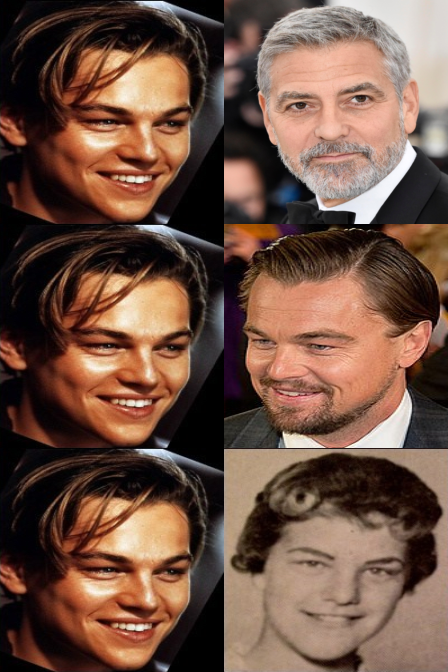

In [ ]:
# visualize your images
show_grid(dataset)

In [ ]:
# compute your embeddings
# warning, this might be slow!
embeddings = compute_embeddings(dataset)

Computing Embeddings (N=6 images)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# compare embeddings (compute eucldian distance between pairs)
results = compare_embeddings(embeddings, image_pairs)
results

,pair_num,image1,image2,euclidean_distance
0,0,DiCaprio_Anchor.jpg,DiCaprio_NegativeClooney.jpg,1.850145
1,1,DiCaprio_Anchor.jpg,DiCaprio_Positive.jpg,1.081127
2,2,DiCaprio_Anchor.jpg,DiCaprio_HardNegative.jpg,0.894828


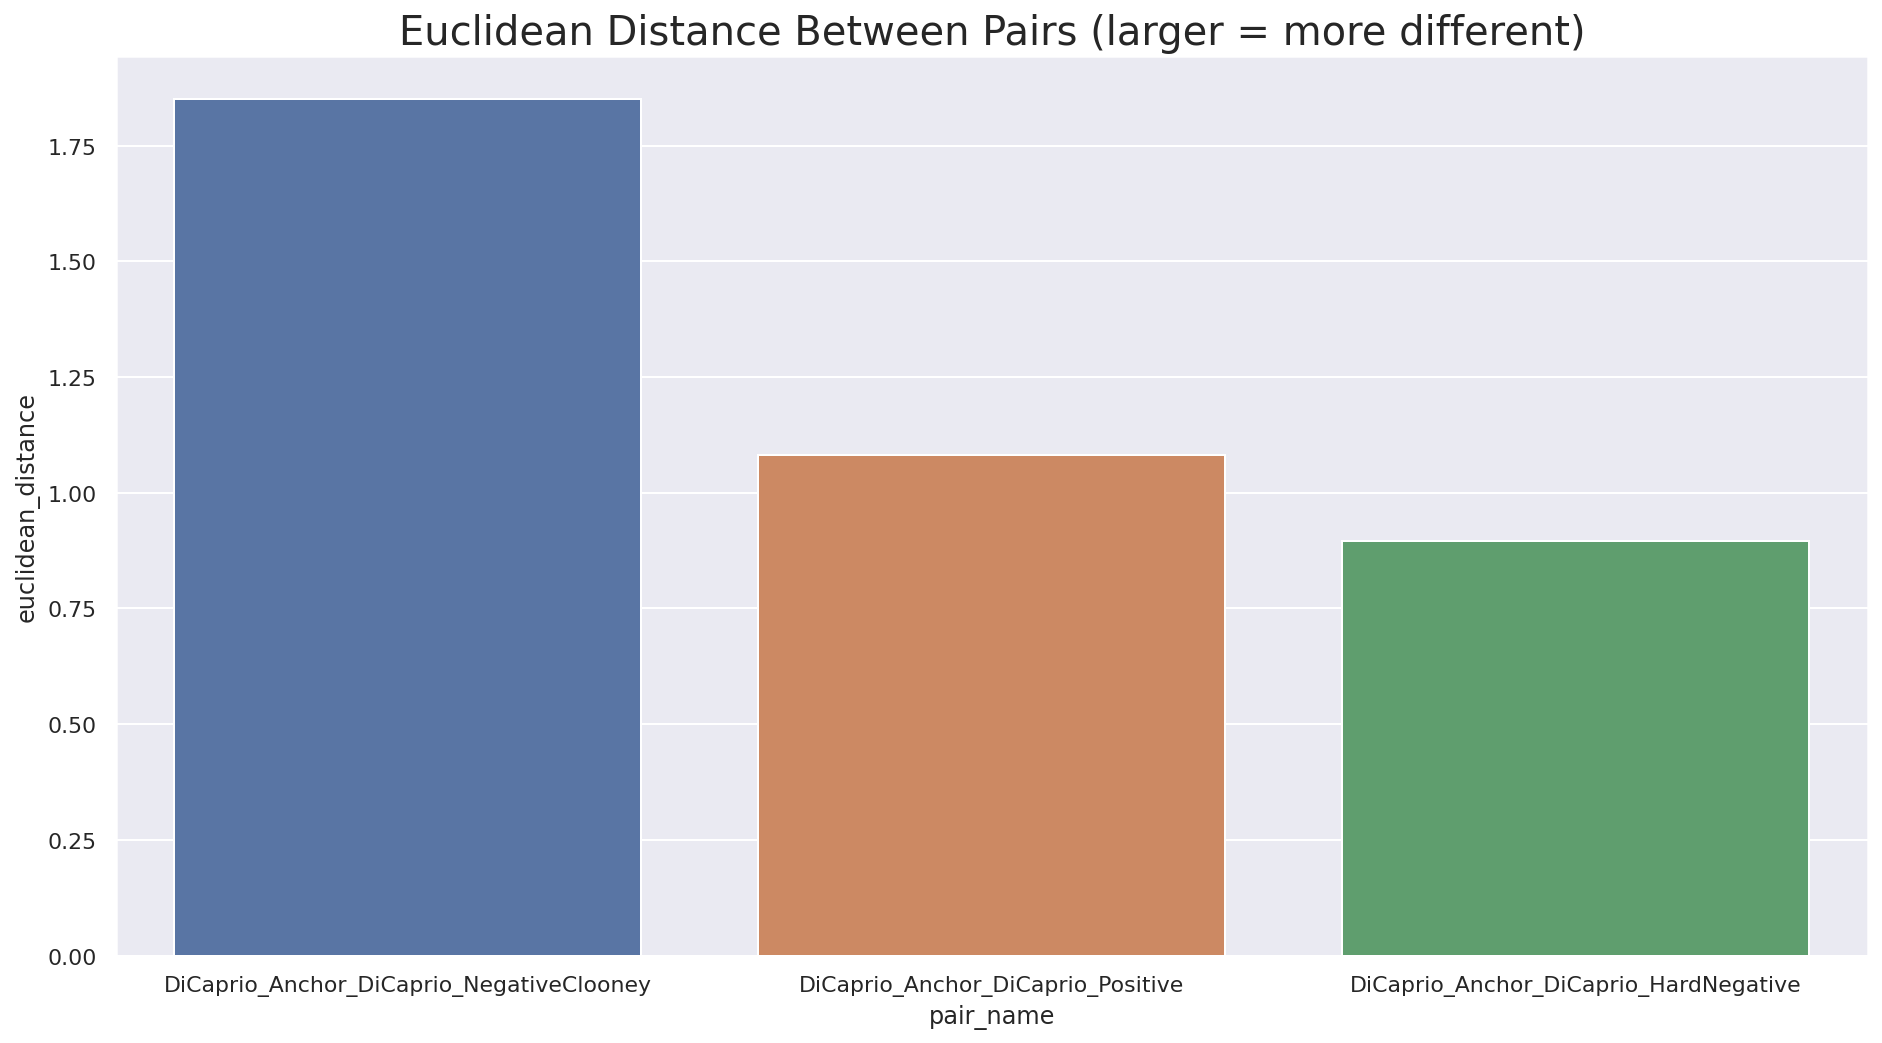

In [ ]:
# plot the results
plot_results(results);

# Step 4 - Document your observations and conclusions

**observations**   
The Leo Anchor is more similar to the other Leo picture (DiCaprio_Positive), than to George Clooney (Negative Clooney), but NOT to the "Hard Negative"!!!

**interpretation**  
The network agrees that the "Hard Negative" Looks more like Leo than other people, or even other pictures of himself.

**discussion**  
Does this agree with your subjective impression? Definitely, but I wonder if the pose matters.

What conclusions would you draw about the network based on these results?
I think this network does a pretty good job capturing face representations, but XYZ...

# Step 5 - Perform Stronger Tests of Your Intuitions

OK, you must have some ideas about what's driving the pattern you see above. Why not test them by creating a few variations on your test? e.g., for this example...

- [ ] how much does this depend on the "head tilt" matching?
- [ ] try a variety of positives and negatives to test your intuitions/ideas
- [ ] try different sets of images to see how well FaceNet performs in general (e.g., goto images.google.com and type "totally looks like" to find a bunch of "hard negatives").
- [ ] try an array of positives (from easy to hard) and an array of negatives (from easy to hard)...Does FaceNet always treat your positives as more similar than your negatives? When does it fail? Can you "see why" it failed (your best guess about which feature led to the error), and then add images (or edit them with photoshop) to test your hypothesis?

If you want to manipulate these images we downloaded to colab, you can download them (hover over the filename, see the three vertical dots to the right of the filename, click on it, and select download). Then you can edit them in whatever software you like (photoshop, preview), and save a copy with a different file name. Then upload the new files to your "images" folder just by dragging and dropping.



# Step 6 - Final Thoughts?

How "good" is the face representation of FaceNet? Where did it succeed, and where did it fail?

Other observations, thoughts, or conclusions?


# Step 7 - Turn in your notebook and ppt slides.

**turn in your powerpoint slides**
- upload your powerpoint file, named Psy1406_YourLastName_YourFirstName_Project1.pptx to the course website

**turn in your notebook**
- Second, you should download a copy of your notebook to upload to the course website. Goto File -> Download -> Download .ipynb -> name file as: Psy1406_YourLastName_YourFirstName_Project1.ipynb
- upload your .ipynb file, along with your images, to the course website